# File Info
Learns non-chaotic lorenz with $\rho(t)$ transitioning from 10 to 14 using piecewise neural odes. 

Uses a custom loss function which weights loss in each partition equally - changed to l1 from MSE

In [3]:
# Import the necessary packages:
    
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
#import Plot3D as plot3d

#Neural ODE library
import NODE_Dynamic_Bifurcation_Parameter.Neural_ODEs_v1 as nodes
import DynamicalSystems as ds


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

ModuleNotFoundError: No module named 'NODE_Dynamic_Bifurcation_Parameter'

# Generating Data

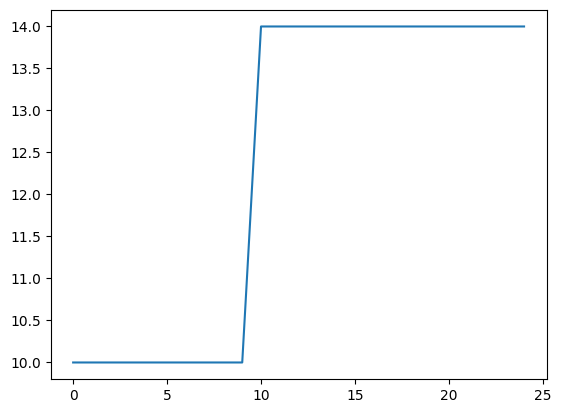

In [ ]:
#r_vals = np.arange(14, 15, 1, dtype=np.float32)
r_vals = [10.0, 14.0]
def rho(t, r_vals = r_vals, step = 10):
    if t < step:
        return r_vals[0]
    elif t >= step:
        return r_vals[1]

plt.plot([rho(t) for t in range(0, 25)])

In [ ]:
lorenz = ds.Lorenz(rho = rho)

#Generating data from Lorenz System with fixed parameters
dt = 0.05
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]
time_spans = [(0, 15)]
list = []

for t_span in time_spans:
    out = lorenz.solve(x0 = initial_conditions, t_span = t_span, dt = dt)
    list.append(np.expand_dims(out, axis=0))

data_full = np.concatenate(list, axis=0)
data_full.shape

(1, 300, 2, 3)

### Normalizing Data

In [ ]:
norm = nodes.normalize_data(data_full.reshape(-1, 3))
data_norm = norm.normalize(data_full)

## Plotting 

In [6]:
def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

    

In [6]:
data_norm[0, :, 0, 0].shape

(300,)

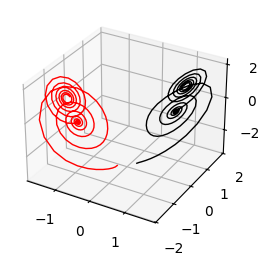

In [7]:

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
ax1.plot(xs=data_norm[0, :, 0, 0], ys=data_norm[0, :, 0, 1], zs=data_norm[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[0, :, 1, 0], ys=data_norm[0, :, 1, 1], zs=data_norm[0, :, 1, 2], color = 'red', linewidth = 1)   



# Training Neural ODE

## Custom Loss function 

In [8]:
class PiecewiseLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn = nn.L1Loss()

    def forward(self, input, target, breakpoints, time_tensor):
        index = torch.searchsorted(time_tensor, breakpoints)
        total_loss = 0.0
        for i in range(index.shape[0]-1):
            input_segment = input[:, index[i]:index[i+1]]
            target_segment = target[:, index[i]:index[i+1]]
            #print('input_segment.shape, target_segment.shape', input_segment.shape, target_segment.shape)
            segment_loss = self.loss_fn(input_segment, target_segment)
            total_loss += segment_loss
            
       

        return total_loss

## Model Setup 

In [9]:
model = nodes.Piecewise_Auto_NODE(spatial_dim=3, depth=2, width = 30, time_range=[0, 15], num_breakpoints=1, activation_func=nn.Tanh())

In [10]:
#Saving loss and setting optimiser 
loss_list = []
breakpt_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
#t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

In [11]:
times = np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])
t_eval_tensor = torch.tensor(times)
t_eval_tensor.shape

torch.Size([1, 300])

## Single Loop 

In [12]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [14]:
model.breakpoints[1] = torch.tensor(10.0)

In [15]:
model.breakpoints[1] = torch.tensor(10.0)
model.break_params = nn.Parameter(torch.tensor([10.0], requires_grad=True))

In [16]:
#Single training loop
optimizer.zero_grad()

pred_x_list = []
for i in range(t_eval_tensor.shape[0]):

    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn = PiecewiseLoss()
train_loss = loss_fn(pred_x, training_data_tensor.float(), breakpoints=model.breakpoints, time_tensor=t_eval_tensor[i, :].float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(9.6922, grad_fn=<AddBackward0>)
Gradient of Breakpoints: tensor([0.4748])



In [ ]:
optimizer.zero_grad()

pred_x = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_tensor[0, :].float(), method='rk4', options={'step_size': dt})


loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor[0, :, :, :].float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(4.9445, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([0.7683])



## Main Training Loop

In [17]:
def batch(data: torch.tensor, t: torch.tensor, batch_length: int, num_batch: int): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).

    Modifed to allow for multiple time spans

    Parameters:
    -----------       
    data : torch.tensor
        The full dataset from which to sample batches. (num_time_spans, time, traj, dim)

    t : torch.tensor
        The corresponding time tensor. (num_time_spans, time)
    '''
    data_length = data.shape[1]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[:, ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[:, ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))
        
        #Each batch has shape (num_time_spans, batch_length, traj, dim) and each batch time has shape (num_time_spans, batch_length)

        return batch_list, batch_time_list

In [18]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [29]:
batch_length = 20
num_batch = 15
num_epochs = 2000
#Loss function will not scale to more time scales. piecewise loss function only takes one timescale. 

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float(), breakpoints=model.breakpoints, time_tensor=batch_time_i[0, :].float()) # Will not scale here 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float(), breakpoints=model.breakpoints, time_tensor=t_eval_tensor[0, :].float()) # same issue here
                breakpt_list.append(model.break_params.item())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     
    
   

  0%|          | 1/2000 [00:02<1:23:10,  2.50s/it]

Epoch 0, Loss: 0.41448453068733215


  1%|          | 21/2000 [00:51<1:31:11,  2.76s/it]

Epoch 20, Loss: 0.40623360872268677


  2%|▏         | 41/2000 [01:50<1:34:30,  2.89s/it]

Epoch 40, Loss: 0.4438321590423584


  3%|▎         | 61/2000 [02:41<1:29:08,  2.76s/it]

Epoch 60, Loss: 0.4313960671424866


  4%|▍         | 81/2000 [03:33<1:31:00,  2.85s/it]

Epoch 80, Loss: 0.42361098527908325


  5%|▌         | 101/2000 [04:29<1:30:16,  2.85s/it]

Epoch 100, Loss: 0.4256990849971771


  6%|▌         | 121/2000 [05:23<1:25:43,  2.74s/it]

Epoch 120, Loss: 0.4162180423736572


  7%|▋         | 141/2000 [06:20<1:30:14,  2.91s/it]

Epoch 140, Loss: 0.42157208919525146


  8%|▊         | 161/2000 [07:16<1:22:20,  2.69s/it]

Epoch 160, Loss: 0.40683814883232117


  9%|▉         | 181/2000 [08:12<1:25:28,  2.82s/it]

Epoch 180, Loss: 0.4038431644439697


 10%|█         | 201/2000 [09:08<1:24:43,  2.83s/it]

Epoch 200, Loss: 0.42624837160110474


 11%|█         | 221/2000 [10:03<1:20:53,  2.73s/it]

Epoch 220, Loss: 0.4264501929283142


 12%|█▏        | 241/2000 [10:56<1:20:32,  2.75s/it]

Epoch 240, Loss: 0.4184659421443939


 13%|█▎        | 261/2000 [11:51<1:23:02,  2.87s/it]

Epoch 260, Loss: 0.3954707384109497


 14%|█▍        | 281/2000 [12:45<1:20:56,  2.83s/it]

Epoch 280, Loss: 0.4146316647529602


 15%|█▌        | 301/2000 [13:40<1:20:03,  2.83s/it]

Epoch 300, Loss: 0.398775190114975


 16%|█▌        | 321/2000 [14:34<1:16:26,  2.73s/it]

Epoch 320, Loss: 0.3850574493408203


 17%|█▋        | 341/2000 [15:30<1:18:45,  2.85s/it]

Epoch 340, Loss: 0.38028043508529663


 18%|█▊        | 361/2000 [16:24<1:17:05,  2.82s/it]

Epoch 360, Loss: 0.39925092458724976


 19%|█▉        | 381/2000 [17:20<1:17:40,  2.88s/it]

Epoch 380, Loss: 0.3719654381275177


 20%|██        | 401/2000 [18:13<1:13:51,  2.77s/it]

Epoch 400, Loss: 0.38589757680892944


 21%|██        | 421/2000 [19:07<1:11:23,  2.71s/it]

Epoch 420, Loss: 0.36960506439208984


 22%|██▏       | 441/2000 [20:02<1:11:37,  2.76s/it]

Epoch 440, Loss: 0.3879666030406952


 23%|██▎       | 461/2000 [20:56<1:11:14,  2.78s/it]

Epoch 460, Loss: 0.3634357452392578


 24%|██▍       | 481/2000 [21:50<1:11:05,  2.81s/it]

Epoch 480, Loss: 0.37020158767700195


 25%|██▌       | 501/2000 [22:44<1:12:20,  2.90s/it]

Epoch 500, Loss: 0.361925333738327


 26%|██▌       | 521/2000 [23:37<1:08:45,  2.79s/it]

Epoch 520, Loss: 0.3596475124359131


 27%|██▋       | 541/2000 [24:31<1:06:51,  2.75s/it]

Epoch 540, Loss: 0.3599233627319336


 28%|██▊       | 561/2000 [25:25<1:05:04,  2.71s/it]

Epoch 560, Loss: 0.3582057058811188


 29%|██▉       | 581/2000 [26:20<1:06:58,  2.83s/it]

Epoch 580, Loss: 0.3375929594039917


 30%|███       | 601/2000 [27:14<1:06:16,  2.84s/it]

Epoch 600, Loss: 0.3535533547401428


 31%|███       | 621/2000 [28:07<1:02:15,  2.71s/it]

Epoch 620, Loss: 0.3493652641773224


 32%|███▏      | 641/2000 [29:00<1:02:13,  2.75s/it]

Epoch 640, Loss: 0.3660059869289398


 33%|███▎      | 661/2000 [29:54<1:01:58,  2.78s/it]

Epoch 660, Loss: 0.3644317388534546


 34%|███▍      | 681/2000 [30:47<1:00:39,  2.76s/it]

Epoch 680, Loss: 0.3366160988807678


 35%|███▌      | 701/2000 [31:42<1:03:35,  2.94s/it]

Epoch 700, Loss: 0.3326656222343445


 36%|███▌      | 721/2000 [32:35<1:00:22,  2.83s/it]

Epoch 720, Loss: 0.33431243896484375


 37%|███▋      | 741/2000 [33:28<57:52,  2.76s/it]  

Epoch 740, Loss: 0.33392781019210815


 38%|███▊      | 761/2000 [34:22<56:31,  2.74s/it]

Epoch 760, Loss: 0.33719056844711304


 39%|███▉      | 781/2000 [35:16<56:26,  2.78s/it]

Epoch 780, Loss: 0.32286158204078674


 40%|████      | 801/2000 [36:10<58:37,  2.93s/it]

Epoch 800, Loss: 0.3400987386703491


 41%|████      | 821/2000 [37:04<53:46,  2.74s/it]

Epoch 820, Loss: 0.3240411579608917


 42%|████▏     | 841/2000 [37:58<54:03,  2.80s/it]

Epoch 840, Loss: 0.31912916898727417


 43%|████▎     | 861/2000 [38:51<52:43,  2.78s/it]

Epoch 860, Loss: 0.3265080749988556


 44%|████▍     | 881/2000 [39:45<51:31,  2.76s/it]

Epoch 880, Loss: 0.3314381539821625


 45%|████▌     | 901/2000 [40:39<50:20,  2.75s/it]

Epoch 900, Loss: 0.3184322416782379


 46%|████▌     | 921/2000 [41:32<49:49,  2.77s/it]

Epoch 920, Loss: 0.32200002670288086


 47%|████▋     | 941/2000 [42:26<49:08,  2.78s/it]

Epoch 940, Loss: 0.3189018964767456


 48%|████▊     | 961/2000 [43:20<49:01,  2.83s/it]

Epoch 960, Loss: 0.3038337230682373


 49%|████▉     | 981/2000 [44:14<47:54,  2.82s/it]

Epoch 980, Loss: 0.34628793597221375


 50%|█████     | 1001/2000 [45:08<45:45,  2.75s/it]

Epoch 1000, Loss: 0.32158422470092773


 51%|█████     | 1021/2000 [46:03<46:00,  2.82s/it]

Epoch 1020, Loss: 0.3258487284183502


 52%|█████▏    | 1041/2000 [46:57<44:42,  2.80s/it]

Epoch 1040, Loss: 0.32223081588745117


 53%|█████▎    | 1061/2000 [47:51<44:33,  2.85s/it]

Epoch 1060, Loss: 0.33682218194007874


 54%|█████▍    | 1081/2000 [48:45<42:17,  2.76s/it]

Epoch 1080, Loss: 0.3345182240009308


 55%|█████▌    | 1101/2000 [49:38<41:06,  2.74s/it]

Epoch 1100, Loss: 0.31045952439308167


 56%|█████▌    | 1121/2000 [50:32<39:42,  2.71s/it]

Epoch 1120, Loss: 0.2977621555328369


 57%|█████▋    | 1141/2000 [51:26<39:57,  2.79s/it]

Epoch 1140, Loss: 0.3066605031490326


 58%|█████▊    | 1161/2000 [52:19<39:38,  2.83s/it]

Epoch 1160, Loss: 0.3201538920402527


 59%|█████▉    | 1181/2000 [53:13<37:26,  2.74s/it]

Epoch 1180, Loss: 0.32362693548202515


 60%|██████    | 1201/2000 [54:07<36:03,  2.71s/it]

Epoch 1200, Loss: 0.3062816858291626


 61%|██████    | 1221/2000 [55:00<35:31,  2.74s/it]

Epoch 1220, Loss: 0.319429874420166


 62%|██████▏   | 1241/2000 [55:54<35:00,  2.77s/it]

Epoch 1240, Loss: 0.3214128017425537


 63%|██████▎   | 1261/2000 [56:48<35:52,  2.91s/it]

Epoch 1260, Loss: 0.30613604187965393


 64%|██████▍   | 1281/2000 [57:42<32:12,  2.69s/it]

Epoch 1280, Loss: 0.30614420771598816


 65%|██████▌   | 1301/2000 [58:35<32:13,  2.77s/it]

Epoch 1300, Loss: 0.296402245759964


 66%|██████▌   | 1321/2000 [59:29<31:04,  2.75s/it]

Epoch 1320, Loss: 0.2949427366256714


 67%|██████▋   | 1341/2000 [1:00:23<30:23,  2.77s/it]

Epoch 1340, Loss: 0.31195876002311707


 68%|██████▊   | 1361/2000 [1:01:16<29:38,  2.78s/it]

Epoch 1360, Loss: 0.32056161761283875


 69%|██████▉   | 1381/2000 [1:02:10<28:31,  2.77s/it]

Epoch 1380, Loss: 0.2978266179561615


 70%|███████   | 1401/2000 [1:03:04<27:48,  2.78s/it]

Epoch 1400, Loss: 0.3145730793476105


 71%|███████   | 1421/2000 [1:03:58<26:45,  2.77s/it]

Epoch 1420, Loss: 0.29606300592422485


 72%|███████▏  | 1441/2000 [1:04:52<26:44,  2.87s/it]

Epoch 1440, Loss: 0.3020201623439789


 73%|███████▎  | 1461/2000 [1:05:46<25:21,  2.82s/it]

Epoch 1460, Loss: 0.30914583802223206


 74%|███████▍  | 1481/2000 [1:06:40<24:36,  2.85s/it]

Epoch 1480, Loss: 0.3035484254360199


 75%|███████▌  | 1501/2000 [1:07:35<23:50,  2.87s/it]

Epoch 1500, Loss: 0.29398205876350403


 76%|███████▌  | 1521/2000 [1:08:29<22:22,  2.80s/it]

Epoch 1520, Loss: 0.3054324984550476


 77%|███████▋  | 1541/2000 [1:09:24<21:26,  2.80s/it]

Epoch 1540, Loss: 0.2878382205963135


 78%|███████▊  | 1561/2000 [1:10:17<20:12,  2.76s/it]

Epoch 1560, Loss: 0.2840690314769745


 79%|███████▉  | 1581/2000 [1:11:11<19:23,  2.78s/it]

Epoch 1580, Loss: 0.282221257686615


 80%|████████  | 1601/2000 [1:12:04<18:30,  2.78s/it]

Epoch 1600, Loss: 0.31566372513771057


 81%|████████  | 1621/2000 [1:12:58<17:15,  2.73s/it]

Epoch 1620, Loss: 0.3152396082878113


 82%|████████▏ | 1641/2000 [1:13:52<16:13,  2.71s/it]

Epoch 1640, Loss: 0.30345672369003296


 83%|████████▎ | 1661/2000 [1:14:45<15:36,  2.76s/it]

Epoch 1660, Loss: 0.29248955845832825


 84%|████████▍ | 1681/2000 [1:15:40<14:39,  2.76s/it]

Epoch 1680, Loss: 0.28978607058525085


 85%|████████▌ | 1701/2000 [1:16:33<13:45,  2.76s/it]

Epoch 1700, Loss: 0.31518417596817017


 86%|████████▌ | 1721/2000 [1:17:27<13:03,  2.81s/it]

Epoch 1720, Loss: 0.34211331605911255


 87%|████████▋ | 1741/2000 [1:18:21<12:05,  2.80s/it]

Epoch 1740, Loss: 0.29870328307151794


 88%|████████▊ | 1761/2000 [1:19:15<11:19,  2.84s/it]

Epoch 1760, Loss: 0.29022160172462463


 89%|████████▉ | 1781/2000 [1:20:09<10:01,  2.75s/it]

Epoch 1780, Loss: 0.287310928106308


 90%|█████████ | 1801/2000 [1:21:04<09:19,  2.81s/it]

Epoch 1800, Loss: 0.2981790006160736


 91%|█████████ | 1821/2000 [1:22:03<08:56,  2.99s/it]

Epoch 1820, Loss: 0.29465731978416443


 92%|█████████▏| 1841/2000 [1:22:56<07:19,  2.77s/it]

Epoch 1840, Loss: 0.2784358561038971


 93%|█████████▎| 1861/2000 [1:23:50<06:31,  2.82s/it]

Epoch 1860, Loss: 0.3450300991535187


 94%|█████████▍| 1881/2000 [1:24:44<05:24,  2.73s/it]

Epoch 1880, Loss: 0.28755778074264526


 95%|█████████▌| 1901/2000 [1:25:38<04:31,  2.74s/it]

Epoch 1900, Loss: 0.2985718846321106


 96%|█████████▌| 1921/2000 [1:26:31<03:38,  2.76s/it]

Epoch 1920, Loss: 0.27739718556404114


 97%|█████████▋| 1941/2000 [1:27:26<02:49,  2.87s/it]

Epoch 1940, Loss: 0.2916839122772217


 98%|█████████▊| 1961/2000 [1:28:18<01:47,  2.75s/it]

Epoch 1960, Loss: 0.2936590015888214


 99%|█████████▉| 1981/2000 [1:29:12<00:52,  2.77s/it]

Epoch 1980, Loss: 0.2974725663661957


100%|██████████| 2000/2000 [1:30:03<00:00,  2.70s/it]


## Plotting results

In [30]:
np.savetxt('Data/PA_NODE_Bif_Lorenz_v7_adjlossL2.csv', np.array(loss_list))

Text(0.5, 0, 'Epochs')

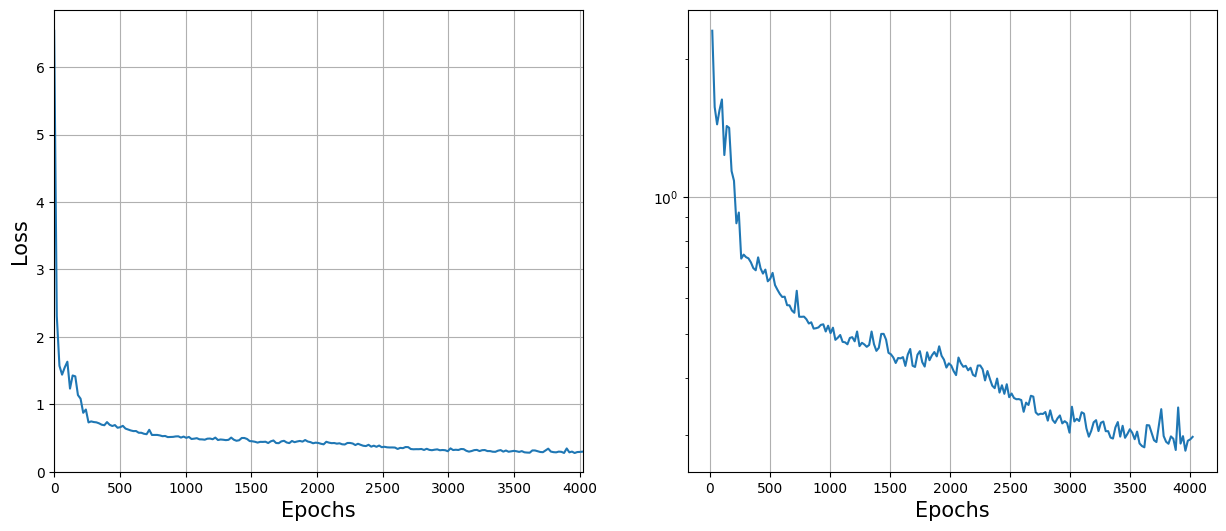

In [31]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [32]:
t_Start_pred = 0; t_Final_pred = 15
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

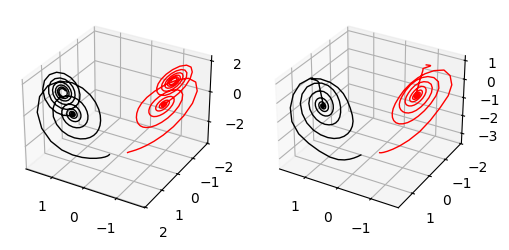

In [33]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[0, :, 0, 0], ys=training_data_tensor[0, :, 0, 1], zs=training_data_tensor[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[0, :, 1, 0], ys=training_data_tensor[0, :, 1, 1], zs=training_data_tensor[0, :, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()

In [26]:

def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[0, :index, 0, 0], ys=data_norm[0, :index, 0, 1], zs=data_norm[0, :index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[0, :index, 1, 0], ys=data_norm[0, :index, 1, 1], zs=data_norm[0, :index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

In [53]:
def plot_interact2(index):
        #Plotting results
        fig = plt.figure(figsize=(6, 8))

        #First Plot
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot(xs=training_data_tensor[0, :index, 0, 0], ys=training_data_tensor[0, :index, 0, 1], zs=training_data_tensor[0, :index, 0, 2], color = 'black', linewidth = 1 )
        ax1.plot(xs=training_data_tensor[0, :index, 1, 0], ys=training_data_tensor[0, :index, 1, 1], zs=training_data_tensor[0, :index, 1, 2], color = 'red', linewidth = 1 )

        #ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
        ax1.view_init(elev = 30, azim = 120)


        #Second Plot 
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot(xs=node_data[:index, 0, 0].detach().numpy(), ys=node_data[:index, 0, 1].detach().numpy(), zs=node_data[:index, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
        ax2.plot(xs=node_data[:index, 1, 0].detach().numpy(), ys=node_data[:index, 1, 1].detach().numpy(), zs=node_data[:index, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

        ax2.view_init(elev = 30, azim = 120)



## Bifurcation Diagram

In [ ]:
a = 1

In [ ]:
np.vectorize(lorenz.f)

In [ ]:
integ.solve_ivp(fun = np.vectorize(lorenz.f), t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', 
                t_eval = np.arange(t_Start, t_Final, dt), )




In [ ]:
r_eval = np.arange(0, 28, 0.1)
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]

t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [ ]:
x_list = []
r_list = []
for r in tqdm(r_eval):
    lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)
      



100%|██████████| 280/280 [02:05<00:00,  2.24it/s]
